In [118]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sklearn as sk
#this last import is used to create our toy dataset
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Example classifier


In [93]:
#We have seen from last time, a simple nn is able to do binary classifaction using BCE with logits
#It is a essentially a logarithmic function that punishes high error for predications far away from true labels
#The largest difference here is that multiclassifcation uses cross entropy.  Additionally, instead of sigmoid,
#MC classifiers use softmax as part of their final layer - meaning that numbers closest to 1 will be closest to the predicted output

In [94]:
#We are going to use an sk learn toy dataset to classify different "blobs" - we will visualize this in a second

In [95]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [96]:
X_blob, y_blob = make_blobs(n_samples = 1000, n_features=NUM_FEATURES, centers = NUM_CLASSES, cluster_std = 1.5, random_state = RANDOM_SEED)

In [97]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, random_state = RANDOM_SEED, test_size = 0.2)

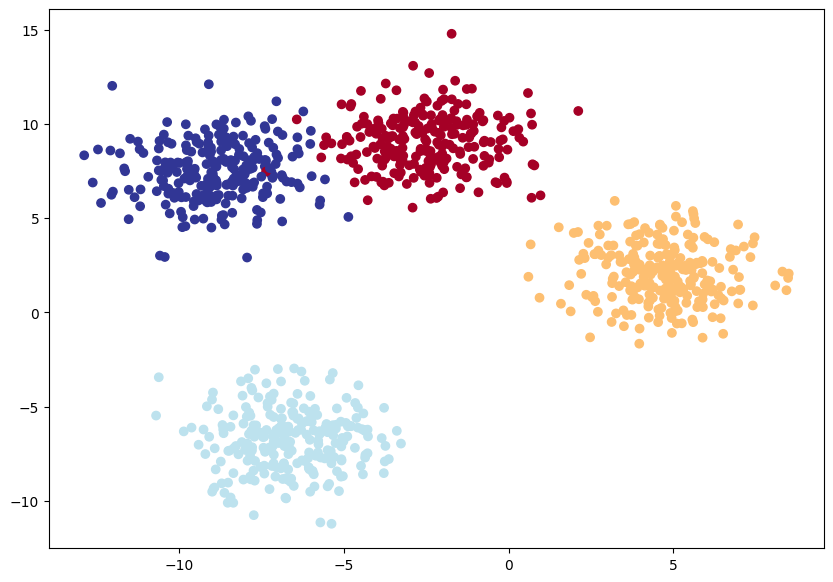

In [98]:
#OK so we have our toy data all split up - let us now do some testing!
plt.figure(figsize=(10,7))

plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [99]:
#Now we are ready to build a multiclassfier!!!! - exciting stuff

Some notes on a multiclassifier - pay attnetion to the differences in classification

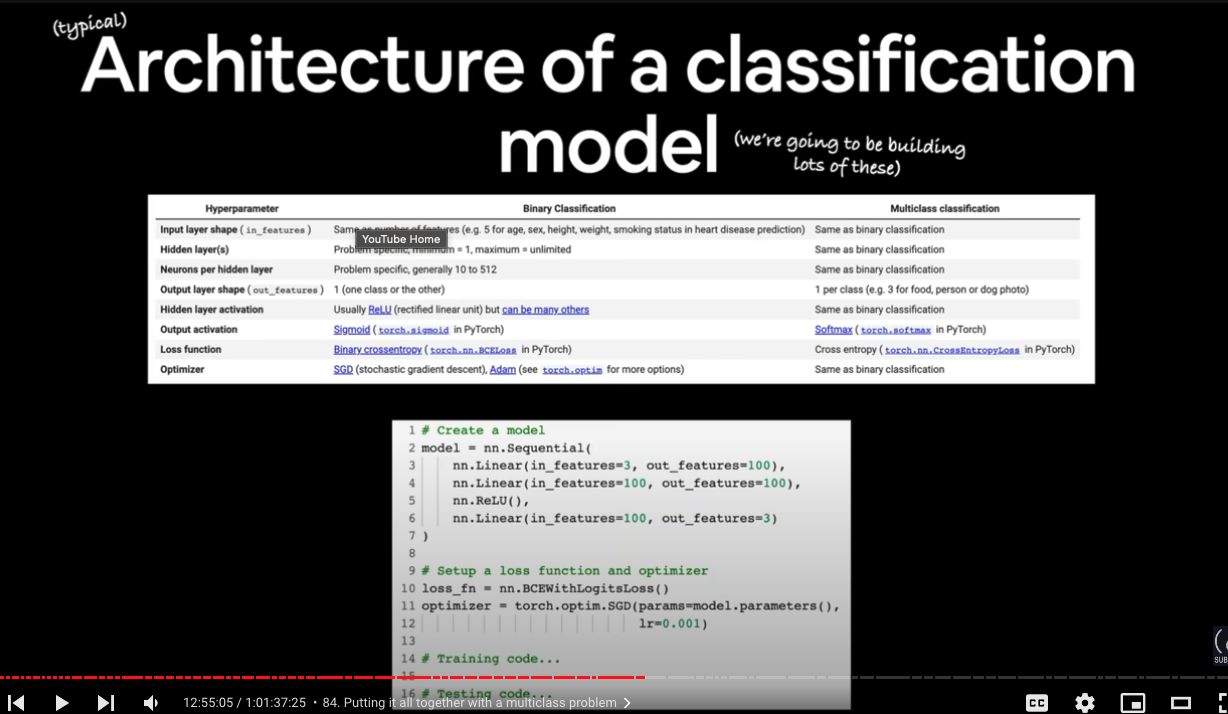

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [101]:
class BlobModel(nn.Module):
  #Initializing our multiclassifier
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layers_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features=output_features)
    )

  def forward(self, X):
    return self.linear_layers_stack(X)


In [102]:
model_0 = BlobModel(input_features = 2, output_features = 4).to(device)

In [103]:
loss_fn = nn.CrossEntropyLoss()

In [104]:
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [105]:
with torch.no_grad():
  y_preds = model_0(X_test.to(device))

In [106]:
#Logits => pred probs use torch.softmax => pred_labels
y_logits = y_preds
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim = 1)
#So as before we have to go logits to pred_probs to

In [107]:
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [108]:
y_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [109]:
#Create a training loop and testing loop!


In [110]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/ len(y_pred)) * 100
  return 100

In [111]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [112]:
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Loop through data
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train)
  y_pred = torch.softmax(y_logits, dim =1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #turns off dropout layers and batch norm
  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_preds)


  if epoch % 10 == 0:
    print(f"Epoch {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch 0 | Loss: 1.1588, Acc: 100.00% | Test Loss: 1.0755, Test Acc: 100.00%
Epoch 10 | Loss: 0.6448, Acc: 100.00% | Test Loss: 0.6607, Test Acc: 100.00%
Epoch 20 | Loss: 0.4254, Acc: 100.00% | Test Loss: 0.4307, Test Acc: 100.00%
Epoch 30 | Loss: 0.2529, Acc: 100.00% | Test Loss: 0.2451, Test Acc: 100.00%
Epoch 40 | Loss: 0.1123, Acc: 100.00% | Test Loss: 0.1023, Test Acc: 100.00%
Epoch 50 | Loss: 0.0663, Acc: 100.00% | Test Loss: 0.0585, Test Acc: 100.00%
Epoch 60 | Loss: 0.0507, Acc: 100.00% | Test Loss: 0.0429, Test Acc: 100.00%
Epoch 70 | Loss: 0.0430, Acc: 100.00% | Test Loss: 0.0349, Test Acc: 100.00%
Epoch 80 | Loss: 0.0384, Acc: 100.00% | Test Loss: 0.0299, Test Acc: 100.00%
Epoch 90 | Loss: 0.0352, Acc: 100.00% | Test Loss: 0.0266, Test Acc: 100.00%


In [113]:
#So our model is working!!!
#Let is visualize to seperate the data using plto decision boundary

model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [115]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [116]:
# Let us go now from pred_probs to pred labels
# How? Torch.argmax

y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [124]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

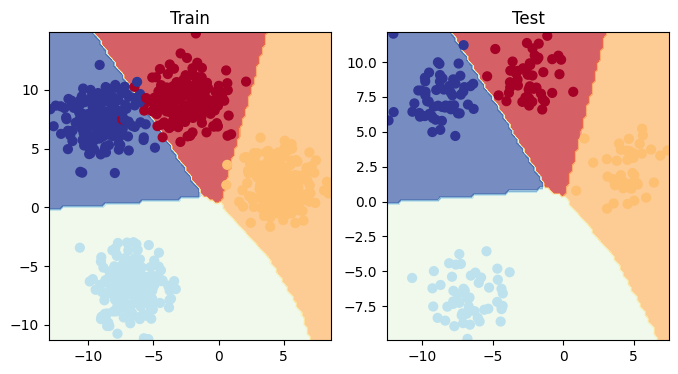

In [127]:

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
#Some other basic things to remember

#Accuracy is the default metric for classification problems -> not the best for imbalanced classes

#Precision - leads to less false positives!

#Recall leads to less false negatives!

In [129]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 19.6 MB/s eta 0:00:00


In [137]:
from torchmetrics.classification import MulticlassAccuracy

num_classes = 4  # Replace with the actual number of classes
torchmetric_accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)

torchmetric_accuracy(y_preds, y_test)

tensor(0.9956, device='cuda:0')

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_np = y_test.cpu().numpy()
y_preds_np = y_preds.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_test_np, y_preds_np)
print(cm)


[[49  0  0  0]
 [ 0 41  0  0]
 [ 0  0 53  0]
 [ 1  0  0 56]]


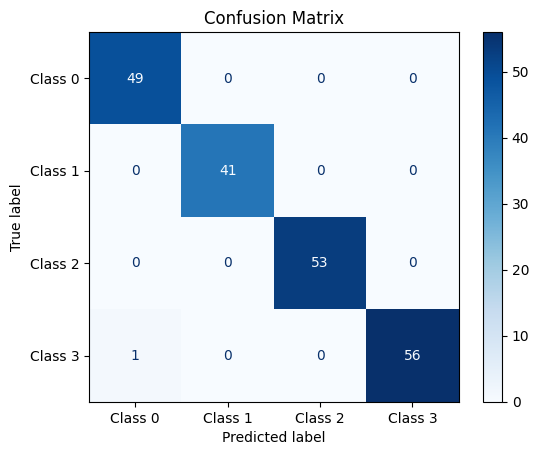

In [149]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Replace with your actual class names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()